In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy
from keras.models import Sequential
from keras.layers import Dense , LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
from os import listdir
from tqdm import tqdm
#Supress scientific notation
pd.options.display.float_format = '{:20,.2f}'.format
import os
import seaborn as sns

In [2]:
os.chdir('./random_split/')

In [ ]:
os.listdir()

In [ ]:
def read_all_shards(partition='cv'):
    shards = []
    for fn in os.listdir(os.path.join(partition)):
        with open(os.path.join(partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_all_shards('test')
cv = read_all_shards('dev')
train = read_all_shards('train')

partitions = {'test': test, 'cv': cv, 'train': train}
for name, df in partitions.items():
    print('"%s" has %d sequences' % (name, len(df)))

In [ ]:
print(train.duplicated().any())
print(cv.duplicated().any())
print(test.duplicated().any())

In [ ]:
train.head()

In [ ]:
df_train = train[0:500000]
df_cv = cv[0:25000]
df_test = test[0:25000]
print("df_train: ", df_train.shape)
print("df_cv  : ", df_cv.shape)
print("df_test : ", df_test.shape)

In [ ]:
print("Unique classes in train :", len(np.unique(df_train.family_accession)))
print("Unique classes in validation :", len(np.unique(df_cv.family_accession)))
print("Unique classes in test :", len(np.unique(df_test.family_accession)))
print("Unique classes in all the three datasets :",len(set(np.unique(df_test.family_accession)).union(set(np.unique(df_cv.family_accession)),set(np.unique(df_train.family_accession)))))

In [ ]:
common_class = set(np.unique(df_test.family_accession)).intersection(set(np.unique(df_cv.family_accession)),set(np.unique(df_train.family_accession)))
print("Common classes :", len(common_class))

In [13]:
df_train = df_train.loc[df_train['family_accession'].isin(common_class)].reset_index()
df_cv = df_cv.loc[df_cv['family_accession'].isin(common_class)].reset_index()
df_test = df_test.loc[df_test['family_accession'].isin(common_class)].reset_index()

In [ ]:
df_train.head()

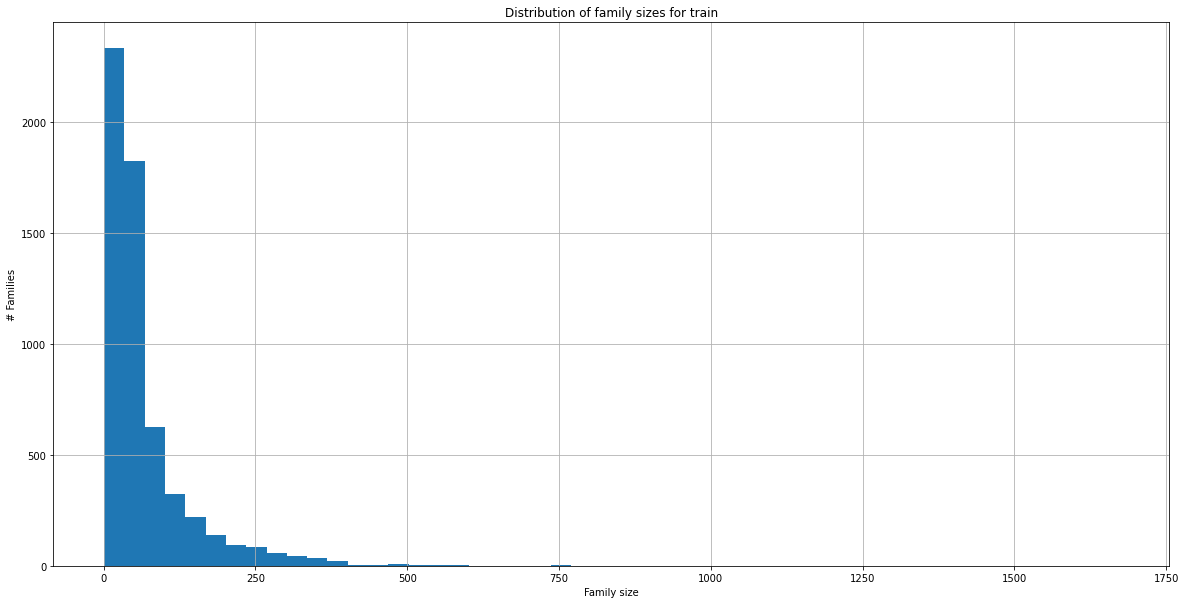

In [ ]:
partitions = {'train': df_train}
plt.figure(figsize=(20,10))
for name, partition in partitions.items():
    partition.groupby('family_accession').size().hist(bins=50)
    plt.title('Distribution of family sizes for %s' % name)
    plt.ylabel('# Families')
    plt.xlabel('Family size')
    plt.show()

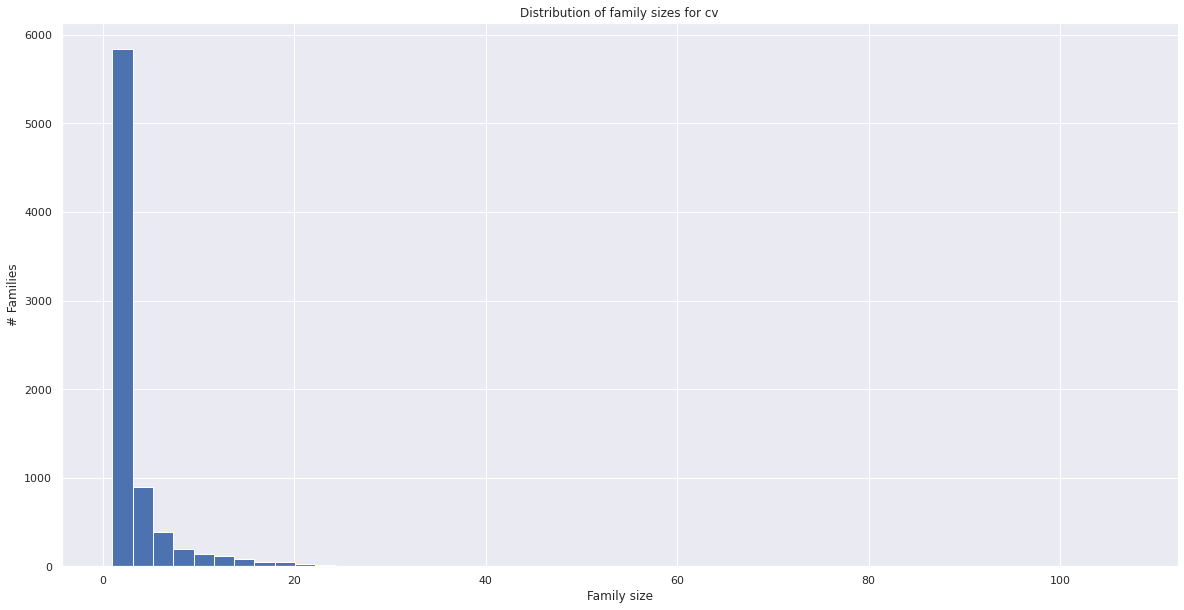

In [ ]:
partitions = {'cv': df_cv}
plt.figure(figsize=(20,10))
for name, partition in partitions.items():
    partition.groupby('family_accession').size().hist(bins=50)
    plt.title('Distribution of family sizes for %s' % name)
    plt.ylabel('# Families')
    plt.xlabel('Family size')
    plt.show()

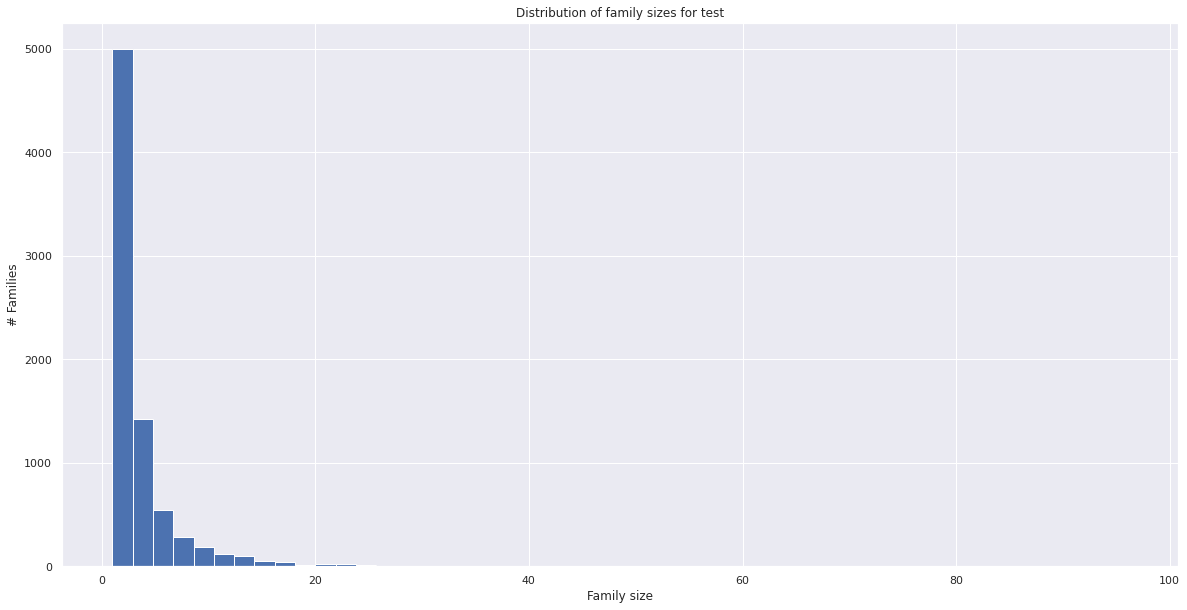

In [ ]:
partitions = {'test': df_test}
plt.figure(figsize=(20,10))
for name, partition in partitions.items():
    partition.groupby('family_accession').size().hist(bins=50)
    plt.title('Distribution of family sizes for %s' % name)
    plt.ylabel('# Families')
    plt.xlabel('Family size')
    plt.show()

In [ ]:
train_des = pd.DataFrame(df_train.sequence.map(len)).describe(include = 'all', percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])
cv_des = pd.DataFrame(df_cv.sequence.map(len)).describe(include = 'all', percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])
test_des = pd.DataFrame(df_test.sequence.map(len)).describe(include = 'all', percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])

Text(0, 0.5, 'length of sequence')

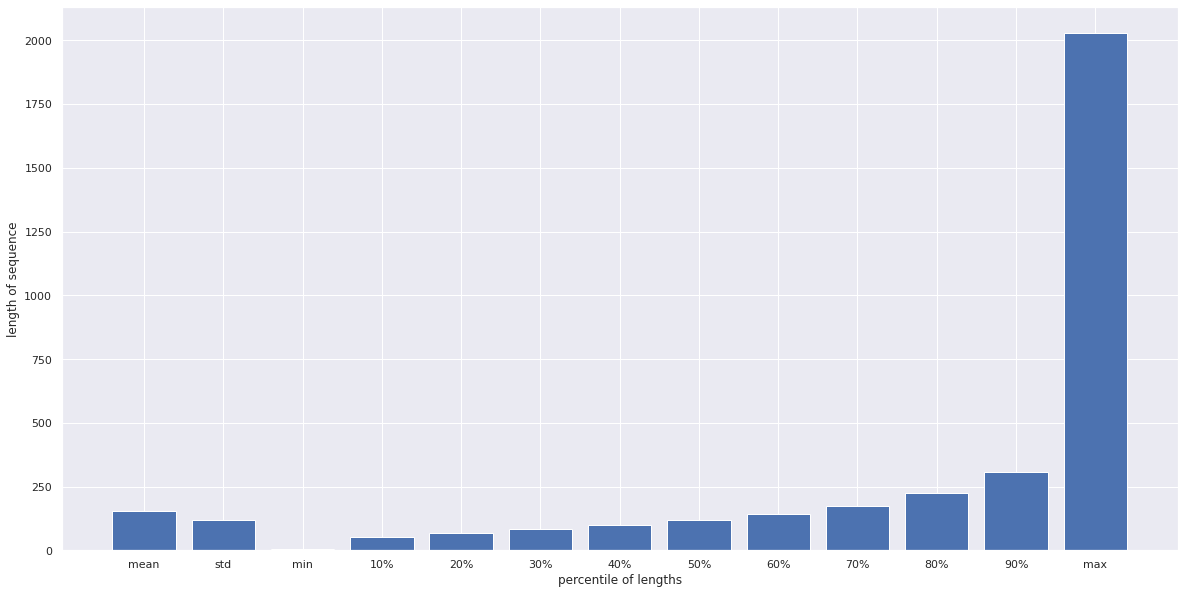

In [ ]:
plt.figure(figsize=(20,10))
y_pos = np.arange(13)
ticks = ['mean','std','min','10%','20%','30%','40%','50%','60%','70%','80%','90%','max']
plt.bar(y_pos ,(train_des[1:].sequence), label='train')
s = plt.xticks(y_pos,ticks)
plt.xlabel('percentile of lengths')
plt.ylabel('length of sequence')

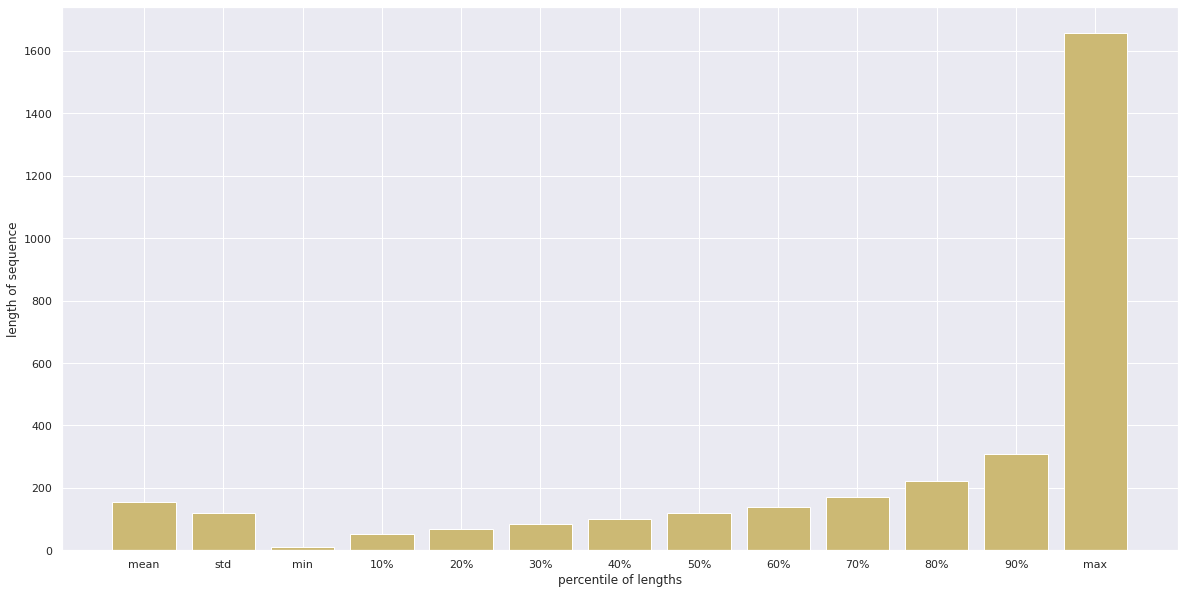

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(y_pos ,cv_des[1:].sequence,color='y')
plt.xlabel('percentile of lengths')
plt.ylabel('length of sequence')
s = plt.xticks(y_pos,ticks)

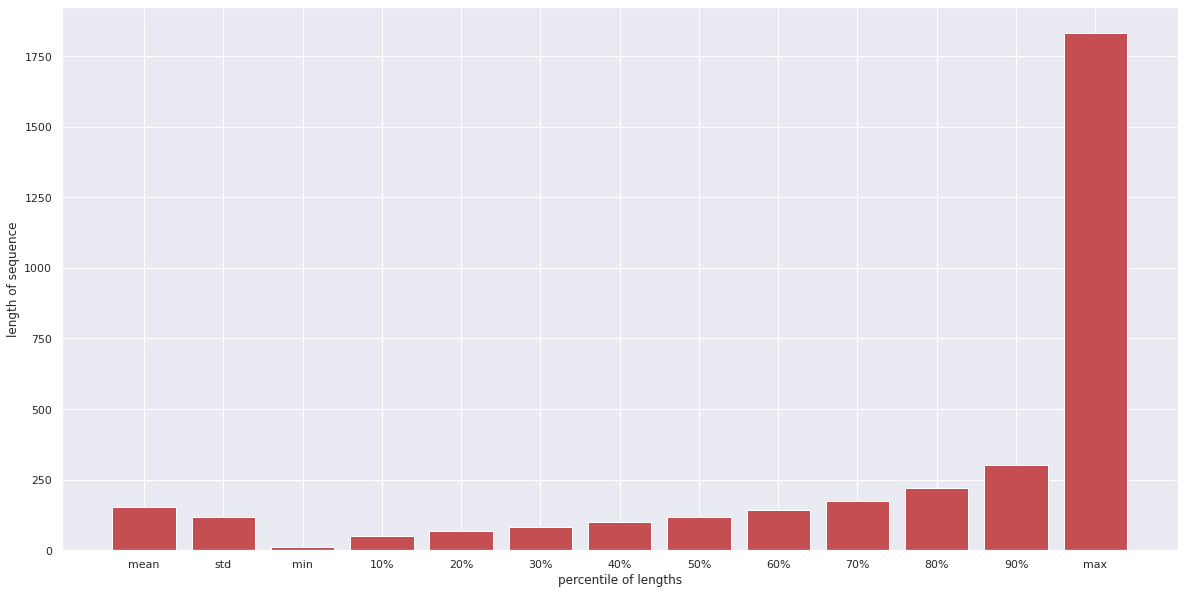

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(y_pos ,test_des[1:].sequence,color='r')
plt.xlabel('percentile of lengths')
plt.ylabel('length of sequence')
s = plt.xticks(y_pos,ticks)

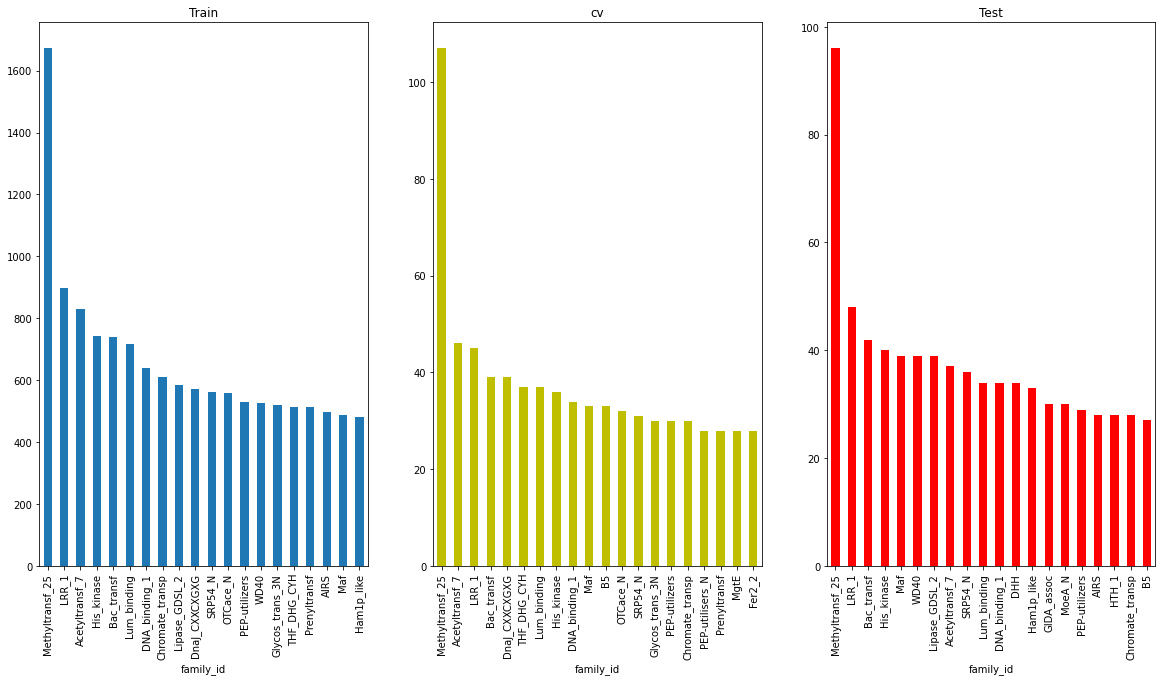

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('Train')
df_train.groupby('family_id').size().sort_values(ascending=False).head(20).plot(kind='bar')
plt.subplot(1,3,2)
plt.title('cv')
df_cv.groupby('family_id').size().sort_values(ascending=False).head(20).plot(kind='bar',color='y')
plt.subplot(1,3,3)
plt.title('Test')
df_test.groupby('family_id').size().sort_values(ascending=False).head(20).plot(kind='bar',color='red')
plt.show()

In [ ]:
df_train["family_accession"].value_counts()

In [9]:
def oversample(df):
    classes = df["family_accession"].value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df["family_accession"] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [10]:
def undersample(df):
    classes = df["family_accession"].value_counts().to_dict()
    # least_class_amount = (max(classes.values())/3)
    least_class_amount = 50
    classes_list = []
    for key in classes:
        classes_list.append(df[df["family_accession"] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [11]:
df_sample=df_cv.copy()

In [12]:
df_sample["family_accession"].value_counts()

PF13649.6     107
PF13508.7      46
PF00560.33     45
PF02397.16     39
PF00684.19     39
             ... 
PF08429.11      1
PF05557.13      1
PF14487.6       1
PF03887.14      1
PF02796.15      1
Name: family_accession, Length: 7818, dtype: int64

In [13]:
df_osample=oversample(df_sample)

In [14]:
df_osample["family_accession"].value_counts()

PF13508.7     107
PF18523.1     107
PF00045.19    107
PF10824.8     107
PF07408.11    107
             ... 
PF08774.11    107
PF07684.12    107
PF06827.14    107
PF01903.17    107
PF13649.6     107
Name: family_accession, Length: 7818, dtype: int64

In [15]:
df_usample=undersample(df_osample)

In [16]:
df_usample["family_accession"].value_counts()

PF13649.6     157
PF00684.19     50
PF00677.17     50
PF06580.13     50
PF01035.20     50
             ... 
PF14487.6      50
PF03887.14     50
PF02796.15     50
PF13616.6      50
PF01866.17     50
Name: family_accession, Length: 7818, dtype: int64

In [ ]:
def resampling(df):
    classes = df["family_accession"].value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df["family_accession"] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    df = final_df

    classes = df["family_accession"].value_counts().to_dict()
    least_class_amount = (classes.values()/3)
    classes_list = []
    for key in classes:
        classes_list.append(df[df["family_accession"] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)

    return final_df

In [ ]:
df_train = resampling(df_train)

In [ ]:
import time
def plt_dynamic( x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    plt.show()

In [ ]:
def space_in_sequence(word):
    '''
    Space in sequence. Example: 'ABCDEFG' to ' A B C D E F G'
    '''
    s_= ''
    for i in range(0, len(word), 1):
        s_ = s_ + ' ' + word[i]
    return s_

def top_freq_features(df, n):
    return df[:n]
space_in_sequence(df_train.sequence[2])

In [17]:
def get_index(word):
    word = word.lower()
    temp = df['feature'] == word
    temp_sum = np.array(temp).sum()
    if(temp_sum ==1):
        return df.index[df['feature'] == word].tolist()[0]
    else:
        return top_words

In [18]:
def right_padding_with_index(x_train, max_seq_length):
    from tqdm import tqdm
    #X_train = numpy.zeros((x_train.shape[0], max_seq_length), dtype = 'int')
    lis =[]
    i = 0
    for j in tqdm(np.arange(0,len(x_train))):
        x = x_train[j]
        x_iter = map(get_index, x.split())
        l1 = list(x_iter)
        lis.append(l1)
    arr = sequence.pad_sequences(lis, maxlen=100, padding='post')
    return arr

In [19]:
from keras.utils import np_utils
def get_categorical(y_train, number_of_unique_classes):
    Y_train = []
    for label in y_train:
        label_ = np_utils.to_categorical(label , number_of_unique_classes) 
        Y_train.append(label_)
    Y_train = np.array(Y_train)
    return Y_train

In [20]:
x_train = (df_train.sequence).apply(space_in_sequence)
x_cv    = (df_cv.sequence).apply(space_in_sequence)
x_test  = (df_test.sequence).apply(space_in_sequence)

In [21]:
values   = np.arange(0,len(df_train.family_accession.unique()),1)
keys = df_train.family_accession.unique()
dict_class = dict(zip(keys, values))

# y_train = df_train.family_accession.apply(lambda x: dict_class[x])
# y_cv    = df_cv.family_accession.apply(lambda x: dict_class[x])
y_test  = df_test.family_accession.apply(lambda x: dict_class[x])

In [ ]:
bow_scalar = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
bow_scalar.fit(x_train.values)

final_counts = bow_scalar.transform(x_train.values).toarray()
final_counts = final_counts.sum(axis=0)
final_counts.shape

In [ ]:
final_counts

In [ ]:
df = pd.DataFrame({ 'feature': bow_scalar.get_feature_names(),'frequency': list(final_counts) })
df.sort_values('frequency', ascending = False, inplace = True)
df.reset_index(drop=True, inplace = True)
df.head(25)

In [27]:
top_words = 20       
max_seq_length = 100  
from tqdm import tqdm
df = top_freq_features(df, top_words)

In [ ]:
df

In [ ]:
unique_indexes = top_words + 1
print("unique_indexes: ", unique_indexes)

In [ ]:
from tqdm import tqdm
if not os.path.isfile('X_train.csv'):
    print("calculating X_train ...")
    %time X_train = right_padding_with_index(x_train[:], max_seq_length)     #performing right padding on our data
    %time pd.DataFrame(X_train).to_csv("X_train.csv", index=False, mode = 'w', header = True)


if not os.path.isfile('X_cv.csv'):
    print("calculating X_cv ...")
    %time X_cv = right_padding_with_index(x_cv[:], max_seq_length)
    %time pd.DataFrame(X_cv).to_csv("X_cv.csv", index=False, mode = 'w', header = True)


if not os.path.isfile('X_test.csv'):
    print("calculating X_test ...")
    %time X_test  = right_padding_with_index(x_test[:], max_seq_length)
    %time pd.DataFrame(X_test).to_csv("X_test.csv", index=False, mode = 'w', header = True)


calculating X_train ...


 28%|██▊       | 56489/204904 [58:59<2:13:02, 18.59it/s]

In [6]:
import numpy as np
def one_hot(final_sequence):
    nb_classes = 21                          
    targets = np.array(final_sequence)
    one_hot_train = np.eye(nb_classes)[targets]
    
    return one_hot_train

In [ ]:
X_train.shape

In [ ]:

# X_train        = pd.read_csv("X_train.csv").values
# %time ohe_train  = one_hot(X_train[:])  
# X_cv           = pd.read_csv("X_cv.csv").values 
# %time ohe_cv     = one_hot(X_cv[:]) 
X_test        = pd.read_csv("X_test.csv").values 
%time ohe_test   = one_hot(X_test[:]) 

# print("X_train: ", ohe_train.shape); print(ohe_train[0:5])
# print("X_cv: ", ohe_cv.shape);       print(ohe_cv[0:5])
print("X_test: ", ohe_test.shape);   print(ohe_test[0:5])

In [35]:
nuq=common_class

In [36]:
# Y_train = get_categorical(y_train , number_of_unique_classes)      
# Y_cv = get_categorical(y_cv , number_of_unique_classes)
Y_test = get_categorical(y_test , number_of_unique_classes)

In [ ]:
np.save('Y_train',Y_train)
np.save('Y_cv',Y_cv)
np.save('Y_test',Y_test)

In [37]:
# Y_train = np.load('Y_train.npy')
# Y_cv = np.load('Y_cv.npy')
Y_test = np.load('Y_test.npy')

In [ ]:
Y_train.shape

(40270, 1483)

In [ ]:
Y_cv.shape

(2946, 1483)

In [37]:
from keras.layers import BatchNormalization,Dropout,Conv1D,Activation,Add,Flatten,Dense
from keras.layers import MaxPooling1D
from keras.layers.merge import concatenate
from keras.initializers import glorot_uniform
from keras.layers import ZeroPadding1D
from keras.models import Input,Model

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
input_seq = Input(shape=(100,21))
print(input_seq.shape)

(None, 100, 21)


In [ ]:
c1= Conv1D(32, 1 , strides=1,padding='causal',dilation_rate = 2, name='conv1d_1', kernel_initializer=glorot_uniform(seed=0))(input_seq)

m1  = MaxPooling1D(pool_size=2)(c1)
b1 = BatchNormalization(axis=2, name='batch_normalization_1')(m1)
a1 = Activation('relu',name='activation_1')(b1)

b2 = BatchNormalization(axis=2, name='batch_normalization_2')(a1)
a2 = Activation('relu',name='activation_2')(b2)

c2 = Conv1D(128, 1 , strides=1,padding='causal',dilation_rate = 2, name='conv1d_3', kernel_initializer=glorot_uniform(seed=0))(a2)

b3 = BatchNormalization(axis=2, name='batch_normalization_3')(c2)
a3 = Activation('relu',name='activation_3')(b3)

c3 = Conv1D(128 , 1 , strides=1 ,padding='causal',dilation_rate = 2, name='conv1d_4' , kernel_initializer=glorot_uniform(seed=0))(a3)

d1 = Dropout(0.5,name='d3')(c3)
m2 = MaxPooling1D(pool_size=2)(d1)

c4 = Conv1D(128,  1 , strides=1 ,padding ='causal',dilation_rate = 2,name='conv1d_2',  kernel_initializer=glorot_uniform(seed=0))(m2)

d2 = Dropout(0.5,name='d7')(c4)
m3 = MaxPooling1D(pool_size=2)(d2)

a4 = Activation('relu',name='activation_4')(m3)
d3 = Dropout(0.2)(a4)
b4 = BatchNormalization(axis=2,name='batch_normalization_4')(d3)
a5 = Activation('relu',name='activation_5')(b4)
d4 = Dropout(0.5,name='dropout_1')(a5)

l1 = LSTM(256)(d4)
f1 = Flatten(name='flatten_1')(l1)

de1 = Dense(5832 ,name='fc' + str(5832), kernel_initializer = glorot_uniform(seed=0))(f1)
a6 = Activation('softmax',name='activation_6')(de1)

In [ ]:
model = Model(inputs = input_seq, outputs = a6)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 21)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           704       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 50, 32)           128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 50, 32)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 50, 32)           128 

In [ ]:
ohe_train.shape

(40270, 100, 21)

In [ ]:
history=model.fit(ohe_train, Y_train, epochs=50, batch_size=256 , causalation_data=(ohe_cv,Y_cv), verbose=1)

Epoch 1/50
158/158 [==============================] - 7s 32ms/step - loss: 5.0275 - accuracy: 0.2620 - val_loss: 7.0957 - val_accuracy: 0.0431
Epoch 2/50
158/158 [==============================] - 5s 29ms/step - loss: 1.5585 - accuracy: 0.7025 - val_loss: 5.3549 - val_accuracy: 0.6236
Epoch 3/50
158/158 [==============================] - 5s 29ms/step - loss: 0.7464 - accuracy: 0.8387 - val_loss: 1.9182 - val_accuracy: 0.8215
Epoch 4/50
158/158 [==============================] - 5s 29ms/step - loss: 0.4444 - accuracy: 0.8966 - val_loss: 1.0257 - val_accuracy: 0.8493
Epoch 5/50
158/158 [==============================] - 5s 29ms/step - loss: 0.2919 - accuracy: 0.9276 - val_loss: 0.8980 - val_accuracy: 0.8530
Epoch 6/50
158/158 [==============================] - 5s 29ms/step - loss: 0.2138 - accuracy: 0.9452 - val_loss: 0.8093 - val_accuracy: 0.8601
Epoch 7/50
158/158 [==============================] - 5s 29ms/step - loss: 0.1599 - accuracy: 0.9567 - val_loss: 0.7784 - val_accuracy: 0.8683

Test score: 0.7527622580528259
Test accuracy: 0.8930686116218567


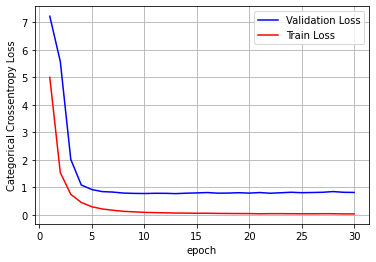

In [ ]:
score = model.evaluate(ohe_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,50+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [8]:
from keras.models import load_model

In [9]:
model = load_model('model.h5')

In [ ]:
score = model.evaluate(ohe_test, Y_test , verbose=1)

In [42]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(ohe_test)

In [ ]:
import numpy as np
y_test_arg=np.argmax(Y_test,axis=1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
print(classification_report(y_test_arg, np.argmax(y_pred, axis=1)))

In [ ]:
print("Test loss:",score[0])
print("Test accuracy:",score[1])

In [45]:
def pred(test_seq):
  max_seq_length = 100  
  print("Input Test Sequence: ",test_seq)
  test_seq=[test_seq]
  df2=pd.DataFrame(test_seq)
  df2.columns=['sequence']
  test2  = (df2.sequence).apply(space_in_sequence)
  Test2  = right_padding_with_index(test2[:], max_seq_length)
  ohe_test2   = one_hot(Test2[:])
  y_pred2 = model.predict(ohe_test2)
  c=np.argmax(y_pred2,axis=1)
  print()
  print("Predicted Protein Family for the inputted sequence: ",keys[c])

In [ ]:
pred("HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE")

In [ ]:
pred("GAVRVDVSGGLGTDAMVVSSYLNTDKSLVTVIVNADNQDRDISLAISGGQPAGAVSVYETSAEHDLAPVRNAGADGRLAVKKQSIVTI")

In [ ]:
pred("AFLFSGRREVMADACLQGMMGCVYGTAGGMDSAAAVLGDFCFLAGKPEERLIAWDYGRQYLLLAPPDAAWRELIKKVLGDRAREHTRYAIKKEGDCFDPGRLRTLAETLPAGITLSRIHGELYGKCLKEEWSRDLVSCFPSCEAYEAMGLGVAALRGNELLAGASSYARSRDAIEIEIDTREDMRNRGLASACGAALILECLERGLYPSWDAHTEISAALAEKLGYHVSHPYVVY")

In [ ]:
pred("LSIFYPIFFVITLIAQLFLMFLIIKHSPKSIHMLRIILGLTCIFQIILAFSAFFVQVRFVTTKKPIEMWSYGVCRHFEPWICYCFYQTEQMSAMASGLTIYGTFYLKYRMVKGVQLTKLEIIKTYAMFFCPFFLSLILVIIIIKTQTLSWESEEQLHLLNYFLYANADYLAIASLSFSKWPNTLNLMIFTSCIIVIPIMCYYCRKKTLSQIYLQLENMSAPRQNLYKSFIMGLSVQCSLPYIFYVPIYTLYYYCLITGREVLFLEFHLTLVPALPAIIDPLVSVYFVTPFRRKIMR")